<a href="https://colab.research.google.com/github/SiriRRR/590-project/blob/main/ag_news_testset_heatmap%26_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install -q transformers torch
 !pip install datasets

In [2]:
from datasets import load_dataset
import pandas as pd
import torch
from transformers.tokenization_utils_base import BatchEncoding
from typing import List, Tuple
from tqdm import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup
from datasets import load_metric

In [3]:
labels = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech",
}
 
K = len(labels)

dataset = load_dataset("ag_news")
dataset

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [4]:

# load fine-tuned classification model before
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification,AdamW, get_linear_schedule_with_warmup

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')
model = DistilBertForSequenceClassification.from_pretrained('SiriRRR/news-classification', num_labels=4, output_hidden_states=True)
if torch.cuda.is_available():
    device = torch.device('cuda:0') # GPU
else:
    device = torch.device('cpu') # CPU
model.to(device)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/860 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [6]:
df_test = dataset['test'].to_pandas()

In [7]:
batch_size = 8
epochs = 4
lr_init = 5e-5
max_len = 256
warmup_steps = 3

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

In [8]:
def batch_data(data: pd.DataFrame, bsize: int) -> List[Tuple[BatchEncoding, List[int], List[str]]]:
    lst = []
    l = len(data)//bsize
    for i in range(l):
        batch_text = data['text'][bsize*i:bsize*(i+1)].tolist()
        X = tokenizer.batch_encode_plus(batch_text, truncation =True, padding= 'max_length',max_length = max_len, add_special_tokens=True, return_tensors='pt')
        #Y = torch.LongTensor(data['label'][bsize*i:bsize*(i+1)].tolist())
        #s = batch_text
        lst.append((X))
    return lst

In [9]:
test_batches = batch_data(df_test, bsize=batch_size)

In [11]:
# get the prediction label by classification model before
def pred_label(batches):
  result_lst=[]

  # frozen model parameters(without train)
  for param in model.parameters():
    param.requires_grad_(False)
  
  # get output of each batch
  for item in batches:
    outputs = model(input_ids=item['input_ids'].to(device), attention_mask =item['attention_mask'].to(device))
    tmp = torch.argmax(outputs.logits, dim=1)
    result_lst = result_lst +tmp.tolist()

  return result_lst

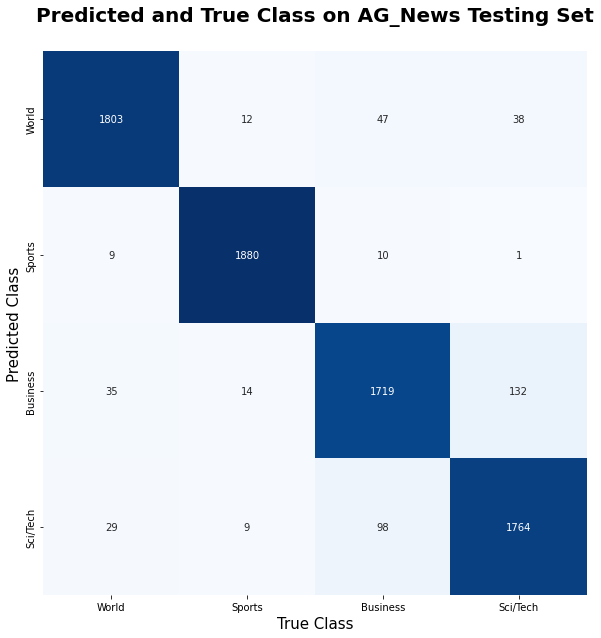

In [59]:
# the confusion matrix heap map for AG_News test data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib

class_lst = ["World","Sports","Business","Sci/Tech"]
plt.figure()
plt.rcParams['figure.figsize'] = [10, 10]
mat = confusion_matrix(test_class, dataset['test']['label'])
sns.heatmap(mat.T, square = True, annot =True, cmap='Blues', fmt ='d', cbar =False,xticklabels = class_lst, yticklabels = class_lst)
plt.xlabel('True Class',fontsize = 15)
plt.ylabel('Predicted Class',fontsize = 15)
plt.title('Predicted and True Class on AG_News Testing Set',fontsize = 20, fontweight='bold',pad=30)
plt.show()